In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import random
from tensorflow.keras.layers import *

In [2]:
TRAIN_PATH = "../input/ml-hackathon/seg_train/seg_train"
VAL_PATH = "../input/ml-hackathon/seg_test/seg_test"
TEST_PATH = "../input/ml-hackathon/seg_pred"
BATCH_SIZE = 32
HEIGHT,WIDTH = 150,150
NUM_CLASSES = 6

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2, 
    zoom_range = 0.2
   )

train_ds = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = True
)


val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
   )

val_ds = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = False
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size = (HEIGHT,WIDTH),
    shuffle = False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [4]:
def create_model():
    pretrained = tf.keras.applications.EfficientNetB7(include_top=False,
                                                      weights='imagenet',
                                                      pooling="avg",
                                                      input_shape=[HEIGHT,WIDTH, 3])
    
    x = pretrained.output
    x = tf.keras.layers.Dropout(0.3) (x)
    x = tf.keras.layers.Dense(128) (x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2) (x)
    x = tf.keras.layers.GaussianDropout(0.4) (x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES,activation="softmax", dtype='float32')(x)
        
    model = tf.keras.Model(pretrained.input, outputs)
    return model

In [5]:
def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
        
    metrics = [
       tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [6]:
def create_callbacks():
    
    cpk_path = './best_model.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

In [7]:
EPOCHS= 30
VERBOSE =1

tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    
    model = create_model()
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks()
    
    history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE)

258080768/258076736 [==============================] - 6s 0us/step
Epoch 1/30
439/439 [==============================] - 314s 645ms/step - loss: 0.9184 - categorical_accuracy: 0.6563 - val_loss: 1.3857 - val_categorical_accuracy: 0.4457

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44567, saving model to ./best_model.h5
Epoch 2/30
439/439 [==============================] - 276s 628ms/step - loss: 0.3511 - categorical_accuracy: 0.8782 - val_loss: 0.4897 - val_categorical_accuracy: 0.8093

Epoch 00002: val_categorical_accuracy improved from 0.44567 to 0.80933, saving model to ./best_model.h5
Epoch 3/30
439/439 [==============================] - 276s 627ms/step - loss: 0.2504 - categorical_accuracy: 0.9114 - val_loss: 0.2534 - val_categorical_accuracy: 0.9120

Epoch 00003: val_categorical_accuracy improved from 0.80933 to 0.91200, saving model to ./best_model.h5
Epoch 4/30
439/439 [==============================] - 275s 625ms/step - loss: 0.2286 - categorical_accuracy: 0.

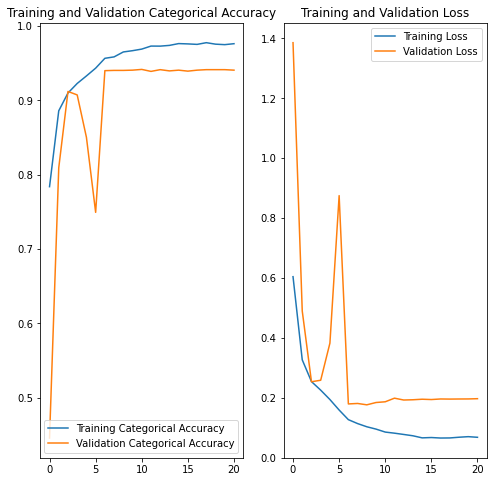

In [8]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
classes_dict = train_ds.class_indices
model = tf.keras.models.load_model("./best_model.h5")
pred = model.predict(test_ds)
predictions = [classes_dict[np.argmax(i)] for i in pred]

pred_df = pd.DataFrame(predictions, columns=['predictions'])
pred_df.to_csv('prediction.csv',index=False)

KeyError: 5